# Map 2D data

This notebook describes an algorithm for how to map 2D data using the (george package), which is based on Gaussian Process Regression  
[https://george.readthedocs.io/en/latest/]. 

An introduction to GP regression can be found here: https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb




To test the function we choose to use temperature data from Argo floats similar to Kuessler and Stein (2018)  
https://doi.org/10.1098/rspa.2018.0400


The function will perform the following steps 

First:
    
* Load a subset of Argo data using argopy
* Linearly interpolate onto pressure levels and select one pressure level for use
* Compute the mean state
* Subtract the mean state from the data to get the anomalies
* The GP is applied to the anomaly data



In [1]:
%matplotlib inline
import xarray as xr
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':14})

In [2]:
# Define region of interest to interpolate

ilat = -10
flat = 10
ilon = -130
flon = -110
idepth = 100
fdepth = 300
idate = "2005-01-01"
fdate = "2006-01-01"
ds = (
    ArgoDataFetcher()
    .region([ilon, flon, ilat, flat, idepth, fdepth, idate, fdate])
    .to_xarray()
)

In [38]:
argo_profiles = ds.argo.point2profile() # Convert points to profiles and 
argo_interp = argo_profiles.argo.interp_std_levels([250]) # Interpolate to pressure levels
selected_vars = argo_interp[["LATITUDE", "LONGITUDE", "TIME", "TEMP"]] #select relevant variables

In [39]:
selected_vars

<xarray.Dataset>
Dimensions:            (N_PROF: 414, PRES_INTERPOLATED: 1)
Coordinates:
    LATITUDE           (N_PROF) float64 9.465 8.144 1.128 ... -3.829 -0.378
    LONGITUDE          (N_PROF) float64 -127.4 -111.7 -124.1 ... -120.0 -127.0
    TIME               (N_PROF) datetime64[ns] 2005-01-01T09:34:05 ... 2005-12-31T23:41:53
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 250
  * N_PROF             (N_PROF) int64 292 238 294 114 0 ... 237 229 328 34 413
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float64 10.43 10.63 ... 12.67
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           isabelle
    Fetched_date:         2020/08/14
    Fetched_constraints:  phy_[x=-130.00/-110.00; y=-10.00/10.00; z=100.0/300...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [4]:
# Compute the background mean

In [5]:
# Define some functions

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
from typing import Iterable


def get_harmonics(nharmonics, time, period=365):
    """Compute the requested number of harmonics
    for a set time.
    
    Parameters
    ----------
    nharmonics : int
        Number of harmonics to compute
    time : int, Iterable
        Time point within period of oscillation.
        This can be either a single int or a 1d-array
    period : int, optional
        Period of oscillation
        
    Returns
    -------
    harmonics: 2d-array
        Array of shape (len(time), nharmonics*2) where
        nharmonics*2 accounts for the cos and sin terms.
    """
    harmonics = np.arange(1, nharmonics + 1)
    if isinstance(time, Iterable):
        time = np.asarray(time)[:, np.newaxis]
        harmonics = harmonics[np.newaxis, :]
    phase = 2 * np.pi * harmonics * time / period
    return np.concatenate([np.cos(phase), np.sin(phase)], axis=-1)


def build_basis(lat, lon, time, nharmonics):
    """Build the 2d local polynomial regression basis
    according to Park2020
    """
    local_polynomlial_reg = np.ones((lat.size, 6 + nharmonics * 2))
    local_polynomlial_reg[:, 1] = lon
    local_polynomlial_reg[:, 2] = lat
    local_polynomlial_reg[:, 3] = lon * lat
    local_polynomlial_reg[:, 4] = lon ** 2
    local_polynomlial_reg[:, 5] = lat ** 2
    local_polynomlial_reg[:, 6:] = get_harmonics(nharmonics, time)
    return local_polynomlial_reg


def find_mean_state(lat, lon, time, data, nharmonics=2):
    """Find the mean state
    
    Parameters
    ----------
    lat, lon, time, data : 1d-array
        Arrays containing latitude, longitude, day of year and
        data.
    nharmonics: int, optional
        Number of harmonics to add into the basis functions
    """
    return lsq_linear(build_basis(lat, lon, time, nharmonics), data)

In [6]:
# Fit the mean

mean_state_fit = find_mean_state(
    selected_vars.LATITUDE,
    selected_vars.LONGITUDE,
    selected_vars.TIME.dt.dayofyear,
    selected_vars.TEMP.data.flatten(),
)

mean_state = np.matmul(build_basis(selected_vars.LATITUDE, selected_vars.LONGITUDE, 40, 2), mean_state_fit.x)


In [7]:
# Get the anomaly

Anomaly = selected_vars.TEMP.squeeze() - mean_state


In [8]:
# Add plot here (world map? )

Text(0.5, 0, 'Longitude')

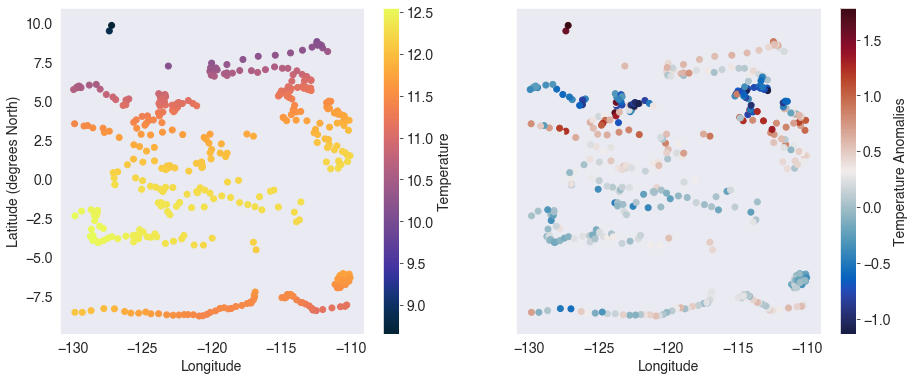

In [40]:
# Plot

import cmocean.cm as cmo

fig, ax = plt.subplots(1,2, figsize=[15,6],sharey=True)
cs1 = ax[0].scatter(selected_vars.LONGITUDE,selected_vars.LATITUDE,c=mean_state, cmap=cmo.thermal)

cbar=plt.colorbar(cs1,ax=ax[0])
cbar.set_label('Temperature')


cs2 = ax[1].scatter( selected_vars.LONGITUDE,selected_vars.LATITUDE,c=Anomaly, cmap=cmo.balance)
cbar=plt.colorbar(cs2,ax=ax[1])
cbar.set_label('Temperature Anomalies')

ax[0].set_ylabel('Latitude (degrees North)')

ax[0].set_xlabel('Longitude')
ax[1].set_xlabel('Longitude')

        

In [10]:
# Now we have the anomaly data that the GP will be computed on


In [47]:
import pandas as pd

# The lon,lat,time coordinates need to be in a specific format for george

Input_coordinates=xr.concat((selected_vars.LONGITUDE,selected_vars.LATITUDE,selected_vars.TIME.dt.dayofyear),pd.Index(['lon','lat','time'], name="coordinate")).T

In [51]:
Input_coordinates[:,2]

<xarray.DataArray 'LONGITUDE' (N_PROF: 414)>
array([  1.,   1.,   6.,   8.,   8.,   9.,  10.,  10.,  11.,  11.,  11.,
        16.,  19.,  19.,  19.,  20.,  20.,  21.,  22.,  27.,  29.,  30.,
        30.,  31.,  31.,  32.,  32.,  37.,  40.,  40.,  40.,  41.,  41.,
        42.,  43.,  48.,  50.,  51.,  51.,  52.,  52.,  53.,  53.,  59.,
        61.,  61.,  62.,  62.,  62.,  63.,  64.,  69.,  71.,  72.,  72.,
        73.,  73.,  74.,  74.,  80.,  82.,  82.,  83.,  83.,  83.,  84.,
        85.,  85.,  86.,  90.,  92.,  93.,  93.,  94.,  94.,  95.,  95.,
        95.,  97., 101., 103., 104., 104., 104., 105., 106., 106., 108.,
       111., 113., 115., 115., 115., 116., 116., 116., 118., 119., 120.,
       122., 122., 124., 125., 125., 125., 126., 127., 127., 129., 130.,
       130., 132., 133., 134., 136., 136., 136., 137., 137., 137., 139.,
       140., 141., 143., 144., 145., 146., 147., 147., 147., 148., 148.,
       150., 151., 151., 153., 154., 155., 157., 157., 158., 158., 158.,
       158., 160., 161., 162., 164., 165., 166., 167., 168., 168., 168.,
       169., 169., 171., 172., 173., 174., 176., 176., 178., 178., 179.,
       179., 179., 179., 181., 183., 184., 185., 186., 187., 188., 189.,
       189., 190., 190., 190., 192., 193., 194., 195., 197., 197., 199.,
       200., 200., 200., 201., 201., 202., 204., 205., 206., 207., 208.,
       209., 210., 211., 211., 211., 211., 213., 215., 215., 217., 218.,
       218., 220., 221., 221., 221., 222., 222., 223., 225., 226., 227.,
       229., 229., 230., 232., 232., 232., 232., 233., 234., 236., 236.,
       238., 239., 239., 241., 242., 242., 243., 243., 243., 245., 246.,
       247., 248., 249., 250., 250., 251., 253., 253., 253., 253., 254.,
       255., 257., 258., 259., 260., 260., 260., 260., 261., 262., 263.,
       263., 264., 264., 265., 266., 268., 268., 269., 270., 271., 271.,
       271., 271., 272., 274., 274., 274., 275., 276., 276., 278., 279.,
       280., 281., 281., 281., 281., 282., 283., 284., 285., 285., 285.,
       286., 287., 289., 290., 290., 292., 292., 292., 292., 292., 293.,
       295., 295., 295., 296., 297., 297., 299., 300., 301., 302., 302.,
       302., 303., 303., 304., 305., 306., 306., 307., 308., 308., 310.,
       311., 311., 313., 313., 313., 313., 314., 314., 316., 316., 317.,
       317., 318., 319., 321., 321., 322., 323., 323., 323., 324., 324.,
       325., 326., 327., 327., 328., 329., 329., 332., 332., 333., 334.,
       334., 334., 334., 335., 335., 337., 338., 338., 338., 339., 340.,
       343., 343., 344., 344., 344., 345., 345., 346., 347., 348., 348.,
       349., 349., 350., 350., 350., 351., 351., 353., 354., 355., 355.,
       355., 356., 356., 356., 358., 359., 359., 359., 360., 360., 360.,
       361., 362., 362., 364., 364., 365., 365.])
Coordinates:
    LONGITUDE   (N_PROF) float64 -127.4 -111.7 -124.1 ... -125.1 -120.0 -127.0
    TIME        (N_PROF) datetime64[ns] 2005-01-01T09:34:05 ... 2005-12-31T23:41:53
    LATITUDE    (N_PROF) float64 9.465 8.144 1.128 ... 2.837 -3.829 -0.378
  * N_PROF      (N_PROF) int64 292 238 294 114 0 35 ... 184 237 229 328 34 413
    coordinate  <U4 'time'

In [12]:
import george as grg

Choose a kernel (covariance) function to model these data, assume a zero mean model

In [79]:
# Define lengthscale

Lxscale = 110e3*np.sin(2*np.pi/360*50)
Lyscale = 110e3

#test larger length scales
Lxscale = 180e3*np.sin(2*np.pi/360*50)
Lyscale = 180e3

# Define kernel (covariance function)
# A simple exponential squared kernel is used, assuming isentropy. 
# There are a number of kernels that can be used

kernel_argo = np.var(Anomaly).values*grg.kernels.ExpSquaredKernel([100e3**2/Lxscale**2, 
                                                100e3**2/Lyscale**2, 
                                                30**2
                                               ], ndim=3)

In [80]:
# Now let us set up the GP. 

gp_argo = grg.GP(kernel_argo)

In [81]:
gp_argo.compute(Input_coordinates, 0.01) # 0.01 is an estimated observational error/ noise

In [82]:
# Define some test grid points

test_pts_argo = np.array(np.meshgrid(np.linspace(-130,-116,30), 
                       np.linspace(-10,10,30),
                        np.linspace(0,365,30))).reshape(3,-1).T
test_pts_argo = xr.DataArray(test_pts_argo,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo.shape[0]), ['lon','lat','time']] ) 

In [83]:
pred_argo, pred_var_argo = gp_argo.predict(Anomaly, test_pts_argo, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred_argo = xr.DataArray(pred_argo,  dims={"test_pt_num"})
pred_var_argo = xr.DataArray(pred_var_argo,  dims={"test_pt_num"})

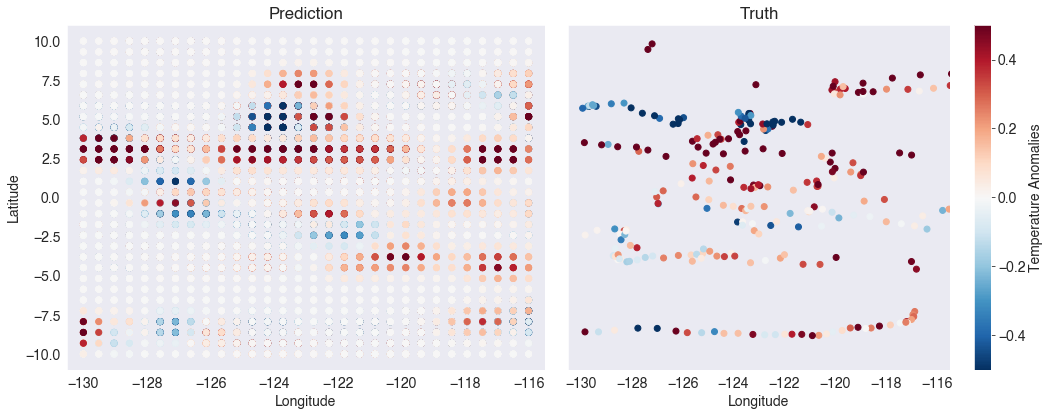

In [84]:
fig,ax=plt.subplots(1,2,figsize=(15,6),sharex=True,sharey=True)


cs=ax[0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
#plt.colorbar(cs,ax=ax[0])
ax[0].set_title('Prediction')

ax[0].set_xlim(-130.5,-115.5)

x_sel = Input_coordinates
y_sel = Anomaly

cs2=ax[1].scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')
ax[1].set_xlabel('Longitude')

cbar=plt.colorbar(cs2,ax=ax[1])
cbar.set_label('Temperature Anomalies')
ax[1].set_title('Truth')

plt.tight_layout()

In [85]:
# Compute the Maximum Likelihood

print("Initial ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Anomaly)))

Initial ln-likelihood: -1354.24


Use Scipys optimize function to fit the maximun likelihood parameters 

In [86]:
from scipy.optimize import minimize


def neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.log_likelihood(Anomaly)

def grad_neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.grad_log_likelihood(Anomaly)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [87]:
%time result_argo = minimize(neg_ln_like_argo,gp_argo.get_parameter_vector(), jac=grad_neg_ln_like_argo)

CPU times: user 2.08 s, sys: 39.7 ms, total: 2.12 s
Wall time: 533 ms


In [88]:
# Optimized likelihood

gp_argo.set_parameter_vector(result_argo.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Anomaly)))



Final ln-likelihood: -216.26


In [89]:
# Here the new prediction is made using the MLE parameter estimates

pred_MLE_argo, pred_var_MLE_argo = gp_argo.predict(Anomaly, test_pts_argo, return_var=True)
pred_MLE_argo = xr.DataArray(pred_MLE_argo,  dims={"test_pt_num"})
pred_var_MLE_argo = xr.DataArray(pred_var_MLE_argo,  dims={"test_pt_num"})

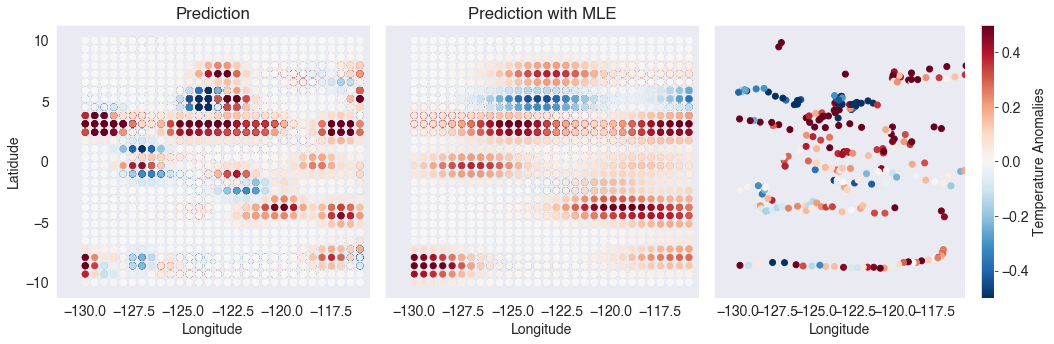

In [90]:
fig,ax= plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)


cs=ax[0].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latidude')
ax[0].set_title('Prediction')

cs2=ax[1].scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_MLE_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
ax[1].set_xlabel('Longitude')
ax[1].set_title('Prediction with MLE')


#x_sel = Input_coordinates.where(np.logical_and(Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
#                               Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
#                                drop='true')

#y_sel = Anomaly.where(np.logical_and(Input_coordinates.sel(coordinate='time')<(2016-1970)*365+60 , 
#                               Input_coordinates.sel(coordinate='time')>(2016-1970)*365-60), 
#                                drop='true')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, cmap='RdBu_r')

#plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
#            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')

x_sel = Input_coordinates
y_sel = Anomaly

cs=ax[2].scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')

ax[2].set_xlabel('Longitude')
cbar=plt.colorbar(cs,ax=ax[2])
cbar.set_label('Temperature Anomalies')
ax[2].set_label('Truth')
ax[2].set_xlim(-131.5, -115.5)

plt.tight_layout()



In [91]:
# Did the MLE change the length scales that we had guessed?
print(gp_argo.parameter_names)
print(np.exp(gp_argo.parameter_vector))

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1', 'kernel:k2:metric:log_M_2_2')
[1.00000000e+00 1.25000000e-12 8.31290485e-02 3.11606183e+00
 4.17266220e-01 1.00556243e+02]


In [92]:
print('Lx(km)='+str((np.exp(gp_argo.parameter_vector[3])*Lxscale**2)**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_argo.parameter_vector[4])*Lyscale**2)**0.5/1e3))
print('Timescale(km)='+str((np.exp(gp_argo.parameter_vector[5]))**0.5))

# These are sensible numbers
# Notice that the method has made the Lx > Ly, and also shrunk the timescale a bit.

Lx(km)=243.4050054140724
Ly(km)=116.27306451901603
Timescale(km)=10.027773585663025


In [ ]:
# What about a time series prediction.

test_pts_argo2 = np.array(np.meshgrid(np.linspace(-144,-136,30), 
                       -50,
                       np.linspace((2013-1970)*365, (2019-1970)*365, 120)
                                     )).reshape(3,-1).T

In [ ]:
test_pts_argo2 = xr.DataArray(test_pts_argo2,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo2.shape[0]), ['lon','lat','time']] ) 

In [ ]:
pred_MLE_argo2, pred_var_MLE_argo2 = gp_argo.predict(Argo_input.Anomaly_data, test_pts_argo2, return_var=True)
# Here the new prediction is made using the MLE parameter estimates.
pred_MLE_argo2 = xr.DataArray(pred_MLE_argo2,  dims={"test_pt_num"})
pred_var_MLE_argo2 = xr.DataArray(pred_var_MLE_argo2,  dims={"test_pt_num"})

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)

plt.scatter(test_pts_argo2.sel(coordinate='lon'), 
            test_pts_argo2.sel(coordinate='time')/365 + 1970 , 
            c=pred_MLE_argo2, vmin=-.5, vmax=.5, s=15, marker='s', cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('time')
plt.colorbar()
plt.xlim([-145, -135])
plt.ylim([2013, 2019])
plt.title('Prediction based on MLE')

plt.subplot(122)
x_sel = Argo_input.Input_coordinates.where(np.logical_and(
                               Argo_input.Input_coordinates.sel(coordinate='time')<(2019-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2013-1970)*365-60) & 
                                           np.logical_and(
                                Argo_input.Input_coordinates.sel(coordinate='lat')<-48, 
                                Argo_input.Input_coordinates.sel(coordinate='lat')>-52), 
                                drop='true')

y_sel = Argo_input.Anomaly_data.where(np.logical_and(
                               Argo_input.Input_coordinates.sel(coordinate='time')<(2019-1970)*365+60 , 
                               Argo_input.Input_coordinates.sel(coordinate='time')>(2013-1970)*365-60) & 
                                           np.logical_and(
                                Argo_input.Input_coordinates.sel(coordinate='lat')<-48, 
                                Argo_input.Input_coordinates.sel(coordinate='lat')>-52), 
                                drop='true')
plt.scatter(x_sel.sel(coordinate='lon'), 
            x_sel.sel(coordinate='time')/365 + 1970, 
            c=y_sel, vmin=-.5, vmax=.5, s=10, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('time')
plt.colorbar()
plt.title('Truth')
plt.xlim([-145, -135])
plt.ylim([2013, 2019])
# A bit hard to see, but some sign of eastward propogation is visible.
# Also since the data ends in 2018, the prediction after that is just 0.

In [ ]:
x_sel = test_pts_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')
y_sel = pred_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')
y_var = pred_var_MLE_argo2.where(np.logical_and(
                                test_pts_argo2.sel(coordinate='lon')<-143.8, 
                                test_pts_argo2.sel(coordinate='lat')>-144.1), 
                                drop='true')

plt.fill_between(x_sel.sel(coordinate='time')/365 + 1970, 
                 y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="b", alpha=0.2)
plt.plot(x_sel.sel(coordinate='time')/365 + 1970, y_sel)
#plt.scatter(test_pts_argo2.sel(coordinate='lon'), 
#            test_pts_argo2.sel(coordinate='time')/365 + 1970 , 
#            c=pred_MLE_argo2, vmin=-.5, vmax=.5, s=15, marker='s', cmap='RdBu_r')
plt.ylabel('Data')
plt.xlabel('time')

plt.title('Prediction based on MLE')

# The prediction of the time series is relatively poor,
# but considering the limited amount of data it is probably not bad.

In [36]:
# Did the MLE change the length scales that we had guessed?
print(gp_argo.parameter_names)
print(np.exp(gp_argo.parameter_vector))

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1', 'kernel:k2:metric:log_M_2_2')
[1.00000000e+00 1.25000000e-12 8.31290486e-02 4.17266215e-01
 3.11606189e+00 1.00556243e+02]


Lx(km)=54.43187104344395
Ly(km)=194.17607705144124
Timescale(km)=10.027773566026227
